### Part I: The Panel

The very first step before doing any causal inference is get loading the data and tranforming them in the right format. Most estimators in this framework require the data to be in form of a `Panel` object. 

Assuming we have the following data frame representing the `CaliforniaProp99` information:

In [1]:
from azcausal.data import CaliforniaProp99

df = CaliforniaProp99().load()

df

State  Year  PacksPerCapita  treated
0           Alabama  1970       89.800003        0
1          Arkansas  1970      100.300003        0
2          Colorado  1970      124.800003        0
3       Connecticut  1970      120.000000        0
4          Delaware  1970      155.000000        0
...             ...   ...             ...      ...
1204       Virginia  2000       96.699997        0
1205  West Virginia  2000      107.900002        0
1206      Wisconsin  2000       80.099998        0
1207        Wyoming  2000       90.500000        0
1208     California  2000       41.599998        1

[1209 rows x 4 columns]

In this example, the columns represent the following:

+ The **units**: are given by each state (`State`)
+ The **time**: is represented in years (`Year`)
+ The **outcome** is the number of packs sold (`PacksPerCapita`)
+ The **intervention** is indicated by the binary treatment column (`treated`)

We define a `Panel` as a data frame where the index represents `time` and each column a `unit`. We can extract the `outcome` from the data frame by:

In [2]:
from azcausal.util import to_matrix

outcome = to_matrix(df, "Year", "State", "PacksPerCapita")

outcome.head(3)

State     Alabama    Arkansas  California    Colorado  Connecticut  \
Year                                                                 
1970    89.800003  100.300003       123.0  124.800003   120.000000   
1971    95.400002  104.099998       121.0  125.500000   117.599998   
1972   101.099998  103.900002       123.5  134.300003   110.800003   

State    Delaware     Georgia       Idaho    Illinois     Indiana  ...  \
Year                                                               ...   
1970   155.000000  109.900002  102.400002  124.800003  134.600006  ...   
1971   161.100006  115.699997  108.500000  125.599998  139.300003  ...   
1972   156.300003  117.000000  126.099998  126.599998  149.199997  ...   

State  South Carolina  South Dakota   Tennessee       Texas       Utah  \
Year                                                                     
1970       103.599998     92.699997   99.800003  106.400002  65.500000   
1971       115.000000     96.699997  106.300003  108.900002  67.699997   
1972       118.699997    103.000000  111.500000  108.599998  71.300003   

State     Vermont    Virginia  West Virginia   Wisconsin     Wyoming  
Year                                                                  
1970   122.599998  124.300003          114.5  106.400002  132.199997  
1971   124.400002  128.399994          111.5  105.400002  131.699997  
1972   138.000000  137.000000          117.5  108.800003  140.000000  

[3 rows x 39 columns]

To check whether the panel data are in fact balanced (we have an entry during each time step for each unit), we can check for `NaN` values in the data frame:

In [3]:
print("Is Balanced:", (~outcome.isna()).all(axis=None))

Is Balanced: True


Let us simulated some data would be missing

In [4]:
imbalanced = to_matrix(df.head(80), "Year", "State", "PacksPerCapita")
print("Is Balanced:", (~imbalanced.isna()).all(axis=None))

imbalanced.head(3)

Is Balanced: False


State     Alabama    Arkansas  California    Colorado  Connecticut  \
Year                                                                 
1970    89.800003  100.300003       123.0  124.800003   120.000000   
1971    95.400002  104.099998       121.0  125.500000   117.599998   
1972   101.099998  103.900002         NaN         NaN          NaN   

State    Delaware     Georgia       Idaho    Illinois     Indiana  ...  \
Year                                                               ...   
1970   155.000000  109.900002  102.400002  124.800003  134.600006  ...   
1971   161.100006  115.699997  108.500000  125.599998  139.300003  ...   
1972          NaN         NaN         NaN         NaN         NaN  ...   

State  South Carolina  South Dakota   Tennessee       Texas       Utah  \
Year                                                                     
1970       103.599998     92.699997   99.800003  106.400002  65.500000   
1971       115.000000     96.699997  106.300003  108.900002  67.699997   
1972              NaN           NaN         NaN         NaN        NaN   

State     Vermont    Virginia  West Virginia   Wisconsin     Wyoming  
Year                                                                  
1970   122.599998  124.300003          114.5  106.400002  132.199997  
1971   124.400002  128.399994          111.5  105.400002  131.699997  
1972          NaN         NaN            NaN         NaN         NaN  

[3 rows x 39 columns]

Instead of extacting only one value at a time, we can also extract multiple directly by 

In [5]:
from azcausal.util import to_matrices

data = to_matrices(df, "Year", "State", "PacksPerCapita", "treated")

data.keys()

dict_keys(['PacksPerCapita', 'treated'])

The reason why we have introduced an object called `Panel` is to combine multiple data frames into one and to have convinient access to information about the time pre and post experiment, as well as control and treatment units. A Panel can be created by passing the *outcome* and *intervention* directly as `pd.DataFrame`:

In [6]:
from azcausal.core.panel import Panel

outcome = data['PacksPerCapita']
intervention = data['treated']

panel = Panel(outcome, intervention)

print(panel.summary())

╭──────────────────────────────────────────────────────────────────────────────╮
|                                    Panel                                     |
|  Time Periods: 31 (19/12)                                  total (pre/post)  |
|  Units: 39 (38/1)                                       total (contr/treat)  |
╰──────────────────────────────────────────────────────────────────────────────╯


which is equivalent to

In [7]:
from azcausal.core.panel import Panel

panel = Panel(outcome='PacksPerCapita', intervention='treated', data=data)

print(panel.summary())

╭──────────────────────────────────────────────────────────────────────────────╮
|                                    Panel                                     |
|  Time Periods: 31 (19/12)                                  total (pre/post)  |
|  Units: 39 (38/1)                                       total (contr/treat)  |
╰──────────────────────────────────────────────────────────────────────────────╯


The panel allows accessing `outcome` and `intervention` directly trough properties:

In [8]:
panel.outcome.head(3)

State     Alabama    Arkansas  California    Colorado  Connecticut  \
Year                                                                 
1970    89.800003  100.300003       123.0  124.800003   120.000000   
1971    95.400002  104.099998       121.0  125.500000   117.599998   
1972   101.099998  103.900002       123.5  134.300003   110.800003   

State    Delaware     Georgia       Idaho    Illinois     Indiana  ...  \
Year                                                               ...   
1970   155.000000  109.900002  102.400002  124.800003  134.600006  ...   
1971   161.100006  115.699997  108.500000  125.599998  139.300003  ...   
1972   156.300003  117.000000  126.099998  126.599998  149.199997  ...   

State  South Carolina  South Dakota   Tennessee       Texas       Utah  \
Year                                                                     
1970       103.599998     92.699997   99.800003  106.400002  65.500000   
1971       115.000000     96.699997  106.300003  108.900002  67.699997   
1972       118.699997    103.000000  111.500000  108.599998  71.300003   

State     Vermont    Virginia  West Virginia   Wisconsin     Wyoming  
Year                                                                  
1970   122.599998  124.300003          114.5  106.400002  132.199997  
1971   124.400002  128.399994          111.5  105.400002  131.699997  
1972   138.000000  137.000000          117.5  108.800003  140.000000  

[3 rows x 39 columns]

In [9]:
panel.intervention.tail(3)

State  Alabama  Arkansas  California  Colorado  Connecticut  Delaware  \
Year                                                                    
1998         0         0           1         0            0         0   
1999         0         0           1         0            0         0   
2000         0         0           1         0            0         0   

State  Georgia  Idaho  Illinois  Indiana  ...  South Carolina  South Dakota  \
Year                                      ...                                 
1998         0      0         0        0  ...               0             0   
1999         0      0         0        0  ...               0             0   
2000         0      0         0        0  ...               0             0   

State  Tennessee  Texas  Utah  Vermont  Virginia  West Virginia  Wisconsin  \
Year                                                                         
1998           0      0     0        0         0              0          0   
1999           0      0     0        0         0              0          0   
2000           0      0     0        0         0              0          0   

State  Wyoming  
Year            
1998         0  
1999         0  
2000         0  

[3 rows x 39 columns]

Moreover, the method also allows to use the most common `pandas` functions on all data included in the panel directly at once:

In [10]:
# for instance only keeping the first 3 units.
new_panel = panel.iloc[:, :3]

new_panel.outcome.head(3)

State     Alabama    Arkansas  California
Year                                     
1970    89.800003  100.300003       123.0
1971    95.400002  104.099998       121.0
1972   101.099998  103.900002       123.5

Also, we can use the `get` method with key word arguments. 

* if `contr == True` then only control units are returned.
* if `treat == True` then units which have been treated at least once are returned.
* if `pre == True` then time steps where no unit is treated is returned.
* if `post == True` then the time steps where at least one unit is treated.

, for example:

In [11]:
panel.get('outcome', post=True, treat=True).head(3)

State  California
Year             
1989    82.400002
1990    77.800003
1991    68.699997

For more methods please check the `Panel` immplementation directly.

Using the `Panel` it is also relatively easy to plot the average control versus treatment by:

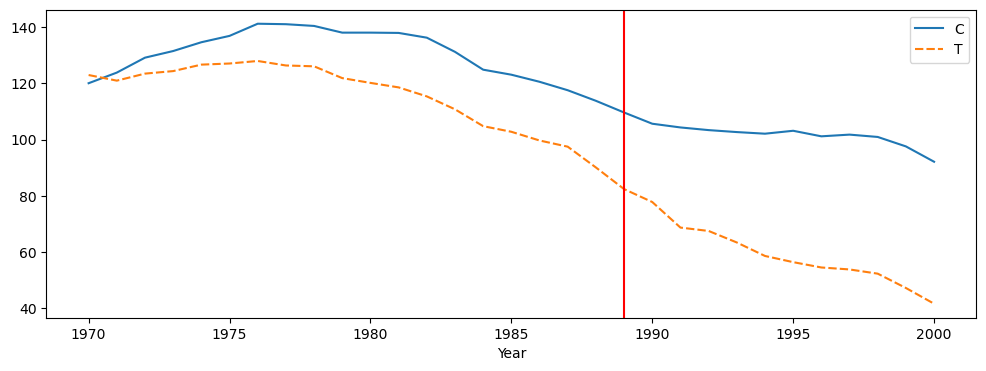

In [12]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12,4)})

import matplotlib.pyplot as plt

avg_control = panel.get('outcome', contr=True).mean(axis=1).to_frame('C')
avg_treat = panel.get('outcome', treat=True).mean(axis=1).to_frame('T')

plt.subplots(1, 1, figsize=(12, 4))
sns.lineplot(avg_control.join(avg_treat))
plt.axvline(panel.start, color='red')